RANDOM VIBRATION SPECIFICATIONS MAGNITUDE EQUATIONS

from https://femci.gsfc.nasa.gov/random/randomequations.html

When performing a random vibration analysis , an input spec is generally given in a form such as the log-log plot inthe figure or written in the table below. The problem is what todo with such information. We cannot input these values directly into nastran because it will not accept a slope in dB/Oct. Individual points in $G^2 /Hz$ vs. $Hz$ are rquired. This page details how to get from the input to graphical points needed.

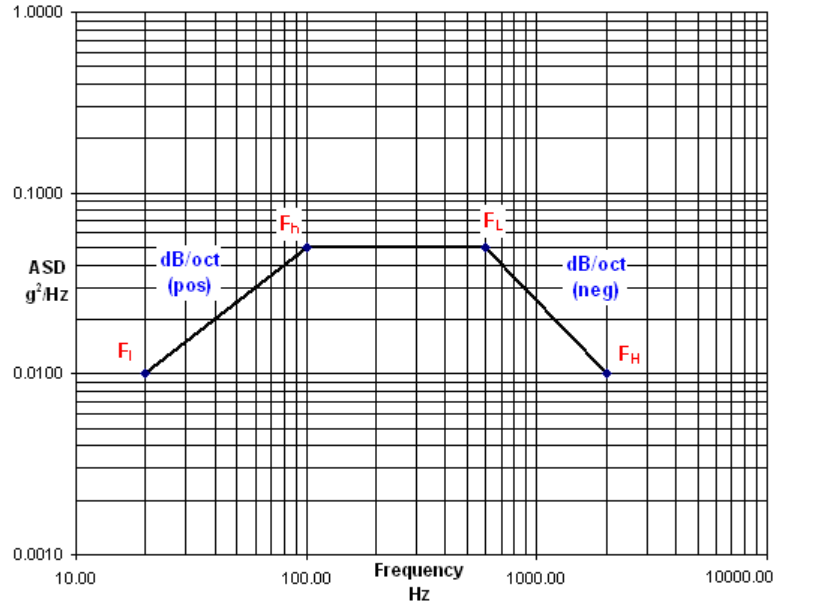


Note that regardless of popular opinion, $G^2/Hz$ is actually an accelerationspectral density (ASD) not a power spectral density (PSD). PSD referes to the actual plot generated during testing, which simply reads the poser output from the accelerometers.

In tabular form, te input may be given in this form (beginning and ending frequencies are not always necessary if a continuous line is assumed:

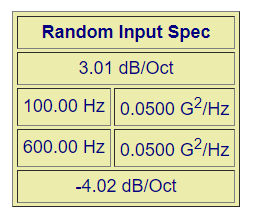

Because no beginning or ending frequencies , $F_I$ and $F_H$ , are given in this table, they must first be decided upon. This is generally project specific. However, the frequency range is usually $20Hz$ to $2000Hz$. From the graph, $F_I = 20Hz$ and $F_H = 2000Hz$. Also, $F_h =100 Hz$ and$F_L = 600 Hz$, respectively.

1 - First, determine the number of octaves between the two frequencies. ket in mind that an octave is the doubling of the frequency. so going from 1Hz to 2Hz is an octave and going from 1000Hz to 2000Hz is also an octave. Thus, the number of octaves could be estimated from the graph above. The equation to calculate the exact number is:

$$Octaves = \dfrac{Log(F_H/F_L)}{Log(2)}$$

Where $F_H$ is the higher frequency and $F_L$ is the lower frequency

2 - Second, determine the number of dB by multiplying the number of octaves by the slope, making sure to use the correct sigh (positive or negative) for the slope.

$dB = \left(\dfrac{dB}{Oct}\right) x (\#Oct) = 10 log(\dfrac{ASD_H}{ASD_L})$


The previous equation also shows the definition of db (see here https://femci.gsfc.nasa.gov/random/dB.html ) where ASD_H and ASD_L are the acceleration spectral densities for the higher and lower frequencies respectively (Not the higher and lower $ASD$ values, that is $ASD_L$ can be greater than $ASD_H$ whereas $F_H$ is always greater than $F_L$.

3 - Finally, solve for the ASD at the desired frequency:

$\dfrac{ASD_H}{ASD_L} = 10^{(dB/10)} $


Further explanations in :  https://femci.gsfc.nasa.gov/random/randomgrms.html

In [1]:
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TESTDATA = StringIO(
"""col1;col2;col3
    1;4.4;99
    2;4.5;200
    3;4.7;65
    4;3.2;140
    """)

# TESTDATA = StringIO(
#     """freq,ASD
#     20.0, 0.0100
#     100.0, 0.0500
#     600.0, 0.0500
#     2000.0, 0.0100"""
# )
 


# BEFORE INCREASE
# TESTDATA = StringIO(
#     """freq,ASD
# 20.00,0.0200
# 50.0,0.0200
# 100.00,0.0200
# 300.00,0.0400
# 500.00,0.0400
# 700.00,0.0400
# 800.00,0.1200
# 925.00,0.1200
# 2000.00,0.0258
# """
# )

# AFTER INCREASE
TESTDATA = StringIO(
    """freq,ASD
20.00,0.04
50.00,0.06
700.00,0.06
800.00,0.12
925.00,0.12
2000.00,0.0258

"""
)

df = pd.read_csv(TESTDATA, sep=",")
# df = pd.read_csv('ASD_input_spectrum.csv', sep=',')

df

,freq,ASD
0,20.0,0.0400
1,50.0,0.0600
2,700.0,0.0600
3,800.0,0.1200
4,925.0,0.1200
5,2000.0,0.0258


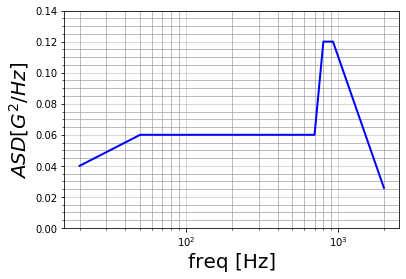

In [56]:
import pylab
fig, ax = plt.subplots()
plt.grid(b=True, which='major', color='#999999', linestyle='-',linewidth=0.5,alpha=0.8 )
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.8)
plt.minorticks_on()


plt.ylim(0,0.14)

plt.xlabel('freq [Hz]', fontsize=20)
plt.ylabel('$ASD [G^2/Hz]$', fontsize=20)
ax.plot(df['freq'], df['ASD'], color='blue', linestyle ='-', linewidth=2.0)
ax.set_xscale('log')
pylab.show()

In [2]:
df['Octaves'] = np.log10(df.freq/df.freq.shift(1))/np.log10(2)
df

,freq,ASD,Octaves
0,20.0,0.0400,NaN
1,50.0,0.0600,1.321928
2,700.0,0.0600,3.807355
3,800.0,0.1200,0.192645
4,925.0,0.1200,0.209453
5,2000.0,0.0258,1.112475


In [4]:
df['dB'] = 10*np.log10(df.ASD/df.ASD.shift(1))
df['m'] = df.dB/df.Octaves
df

,freq,ASD,Octaves,dB,m
0,20.0,0.0400,NaN,NaN,NaN
1,50.0,0.0600,1.321928,1.760913,1.332079
2,700.0,0.0600,3.807355,0.000000,0.000000
3,800.0,0.1200,0.192645,3.010300,15.626145
4,925.0,0.1200,0.209453,0.000000,0.000000
5,2000.0,0.0258,1.112475,-6.675615,-6.000689


In [5]:

# Formulae extracted from: https://femci.gsfc.nasa.gov/random/randomgrms.html
ten_log2 =10*np.log10(2)
df['A'] = ten_log2*(df.ASD/(ten_log2+df.m)) * (df.freq - df.freq.shift(1)* (df.freq.shift(1)/df.freq )**(df.m/(ten_log2)))

# If m = -10log(2), normal formula does not hold, due to a division by zero in the exponent.
df.loc[ abs( df['m'] + ten_log2) < 0.001 , 'A'] = df.ASD.shift(1) * df.freq.shift(1) *np.log(df.freq/df.freq.shift(1))

# column with cumulative sum
df['A_csum'] = df['A'].cumsum()
df

,freq,ASD,Octaves,dB,m,A,A_csum
0,20.0,0.0400,NaN,NaN,NaN,NaN,NaN
1,50.0,0.0600,1.321928,1.760913,1.332079,1.525123,1.525123
2,700.0,0.0600,3.807355,0.000000,0.000000,39.000000,40.525123
3,800.0,0.1200,0.192645,3.010300,15.626145,8.722490,49.247612
4,925.0,0.1200,0.209453,0.000000,0.000000,15.000000,64.247612
5,2000.0,0.0258,1.112475,-6.675615,-6.000689,59.795494,124.043106


In [57]:
Total_Area = round(df['A'].sum(),3)
Grms = round(np.sqrt(Total_Area),3)

print(  'Total_Area   :  ' + str(Total_Area)+ '   Hz*G/s2 ')
print(  'Grms         :   ' + str(Grms) + '   m/s2')
print(  '3*Sigma Grms :   ' + str(3*Grms) + '   m/s2')

Total_Area   :  124.043   Hz*G/s2 
Grms         :   11.137   m/s2
3*Sigma Grms :   33.411   m/s2
